In [ ]:

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io

import html
import time
import dlib

In [ ]:
# prompt: print la version de dlib

print(dlib.__version__)


19.24.4


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch

import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.9/78.2 GB disk)


In [ ]:
import torch

# Charger un modèle pré-entraîné depuis Ultralytics
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)  # Ici, 'yolov5s' peut être remplacé par 'yolov5m', 'yolov5l', ou 'yolov5x' selon le modèle désiré
# Afficher les noms des classes
print(model.names)
# Supposons que model.names soit un dictionnaire
# Vous devez d'abord comprendre comment les données sont structurées dans ce dictionnaire.
print(model.names)  # Imprimez pour comprendre la structure

# Supposons que model.names soit un dictionnaire
# Vous devez d'abord comprendre comment les données sont structurées dans ce dictionnaire.
print(model.names)  # Imprimez pour comprendre la structure

# Si model.names est un dictionnaire et contient les noms des classes sous une certaine clé
if isinstance(model.names, dict):
    class_names = list(model.names.values())  # ou list(model.names.keys()) selon la structure
    if 'cell phone' in class_names:
        cell_phone_index = class_names.index('cell phone')
        print("L'index pour la classe 'cell phone' est :", cell_phone_index)
    else:
        print("La classe 'cell phone' n'est pas dans les classes du modèle.")
else:
    # Si c'est une liste, utilisez directement
    if 'cell phone' in model.names:
        cell_phone_index = model.names.index('cell phone')
        print("L'index pour la classe 'cell phone' est :", cell_phone_index)
    else:
        print("La classe 'cell phone' n'est pas dans les classes du modèle.")



Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [ ]:

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """

  image_bytes = b64decode(js_reply.split(',')[1])

  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)

  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """

  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()

  bbox_PIL.save(iobuf, format='png')

  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)


  data = eval_js('takePhoto({})'.format(quality))

  img = js_to_image(data)

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)

  faces = face_cascade.detectMultiScale(gray)

  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


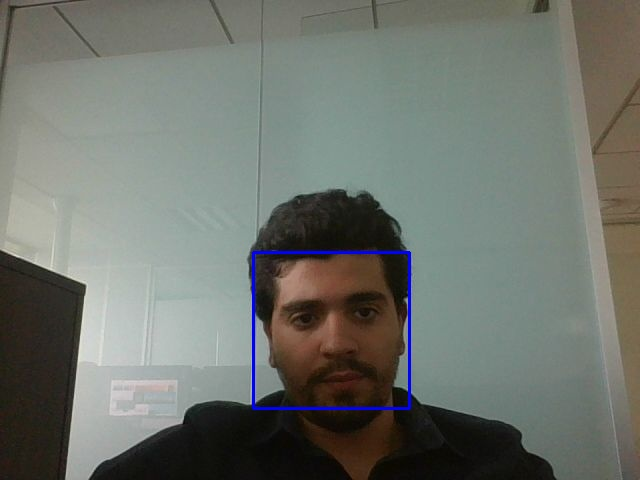

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:

  print(str(err))

In [ ]:
import numpy as np
import math
import cv2

# 3D model points.
model_points = np.array([
    (0.0, 0.0, 0.0),
    (0.0, -330.0, -65.0),
    (-225.0, 170.0, -135.0),
    (225.0, 170.0, -135.0),
    (-150.0, -150.0, -125.0),
    (150.0, -150.0, -125.0)
])

def isRotationMatrix(R):
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype=R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

def rotationMatrixToEulerAngles(R):
    assert(isRotationMatrix(R))
    sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    singular = sy < 1e-6
    if not singular:
        x = math.atan2(R[2, 1], R[2, 2])
        y = math.atan2(-R[2, 0], sy)
        z = math.atan2(R[1, 0], R[0, 0])
    else:
        x = math.atan2(-R[1, 2], R[1, 1])
        y = math.atan2(-R[2, 0], sy)
        z = 0
    return np.array([x, y, z])


def getHeadTiltAndCoords(size, image_points, frame_height):
    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array([[focal_length, 0, center[0]], [
        0, focal_length, center[1]], [0, 0, 1]], dtype="double")

    dist_coeffs = np.zeros((4, 1))
    (_, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points,
                                                                  camera_matrix, dist_coeffs,
                                                                  flags = cv2.SOLVEPNP_ITERATIVE)
    (nose_end_point2D, _) = cv2.projectPoints(np.array(
        [(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    head_tilt_degree = abs(
        [-180] - np.rad2deg([rotationMatrixToEulerAngles(rotation_matrix)[0]]))
    starting_point = (int(image_points[0][0]), int(image_points[0][1]))
    ending_point = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

    ending_point_alternate = (ending_point[0], frame_height // 2)

    return head_tilt_degree, starting_point, ending_point, ending_point_alternate


In [ ]:
from scipy.spatial import distance as dist

def mouth_aspect_ratio(mouth):
    A = dist.euclidean(mouth[2], mouth[10])
    B = dist.euclidean(mouth[4], mouth[8])
    C = dist.euclidean(mouth[0], mouth[6])
    mar = (A + B) / (2.0 * C)
    return mar

In [ ]:
from scipy.spatial import distance as dist

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear



In [ ]:
from IPython.display import display, Javascript

def video_stream():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();
            video = null;
            div = null;
            stream = null;
            imgElement = null;
            captureCanvas = null;
            labelElement = null;
        }

        function onAnimationFrame() {
            if (!shutdown) {
                window.requestAnimationFrame(onAnimationFrame);
            }
            if (pendingResolve) {
                var result = "";
                if (!shutdown) {
                    captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                    result = captureCanvas.toDataURL('image/jpeg', 0.8);
                }
                var lp = pendingResolve;
                pendingResolve = null;
                lp(result);
            }
        }

        async function createDom() {
            if (div !== null) {
                return stream;
            }

            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);

            const modelOut = document.createElement('div');
            modelOut.innerHTML = "Status:";
            labelElement = document.createElement('span');
            labelElement.innerText = 'No data';
            labelElement.style.fontWeight = 'bold';
            modelOut.appendChild(labelElement);
            div.appendChild(modelOut);

            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };
            stream = await navigator.mediaDevices.getUserMedia({video: { facingMode: "environment"}});
            div.appendChild(video);

            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => { shutdown = true; };
            div.appendChild(imgElement);

            const instruction = document.createElement('div');
            instruction.innerHTML = 'When finished, click here or on the video to stop this demo';
            div.appendChild(instruction);
            instruction.onclick = () => { shutdown = true; };

            video.srcObject = stream;
            await video.play();

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = 640;
            captureCanvas.height = 480;
            window.requestAnimationFrame(onAnimationFrame);

            return stream;
        }

        async function stream_frame(label, imgData) {
            if (shutdown) {
                removeDom();
                shutdown = false;
                return '';
            }

            var preCreate = Date.now();
            stream = await createDom();

            var preShow = Date.now();
            if (label != "") {
                labelElement.innerHTML = label;
            }

            if (imgData != "") {
                var videoRect = video.getClientRects()[0];
                imgElement.style.top = videoRect.top + "px";
                imgElement.style.left = videoRect.left + "px";
                imgElement.style.width = videoRect.width + "px";
                imgElement.style.height = videoRect.height + "px";
                imgElement.src = imgData;
            }

            var preCapture = Date.now();
            var result = await new Promise(function(resolve, reject) {
                pendingResolve = resolve;
            });
            shutdown = false;

            return {'create': preShow - preCreate, 'show': preCapture - preShow, 'capture': Date.now() - preCapture, 'img': result};
        }
    ''')
    display(js)

def video_frame(label, bbox):
    data = eval_js(f'stream_frame("{label}", "{bbox}")')
    return data


In [ ]:
def nose_aspect_ratio(nose):
    vertical_distance = dist.euclidean(nose[0], nose[2])
    depth_distance = dist.euclidean(nose[0], nose[1])
    nar = depth_distance / vertical_distance

    return nar

In [ ]:
import numpy as np

def calculate_head_angle(eye_left, eye_right, nose_tip):
    eye_center = (eye_left + eye_right) / 2
    vector_nose = nose_tip - eye_center
    vector_horizontal = (eye_right - eye_left)
    vector_horizontal[1] = 0
    vector_nose_normalized = vector_nose / np.linalg.norm(vector_nose)
    vector_horizontal_normalized = vector_horizontal / np.linalg.norm(vector_horizontal)
    angle_rad = np.arccos(np.clip(np.dot(vector_nose_normalized, vector_horizontal_normalized), -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)

    return angle_deg


In [ ]:
old_gray = None
p0 = None
lk_params = {
    'winSize': (15, 15),
    'maxLevel': 2,
    'criteria': (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
}

def track_landmarks(img, gray, landmarks_points):
    global old_gray, p0
    if old_gray is None:
        p0 = np.array([[x, y] for (x, y) in landmarks_points], dtype=np.float32)
        old_gray = gray.copy()
        return landmarks_points

    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray, p0, None, **lk_params)
    old_gray = gray.copy()
    if p1 is not None and st.flatten().any():
        p1 = p1[st.flatten() == 1]
        p0 = p1.reshape(-1, 1, 2)
        return p1.reshape(-1, 2).tolist()
    else:
        p0 = None
        return []





In [ ]:
from imutils import face_utils
import argparse
import imutils
from IPython.display import HTML, display
video_stream()
time.sleep(2.0)
from IPython.display import Audio, display

s1= '/content/ouvrez_les_yeux.mp3'
s2 = '/content/regardez_devant.mp3'
s3 = '/content/reposer_vous.mp3'
def play_sound(audio_file):
    audio = Audio(audio_file, autoplay=True)
    display(audio)
    display(HTML("<style>audio{visibility: hidden;}</style>"))
def initialize_trackers(img, landmarks_points):
    global multi_tracker
    multi_tracker = cv2.legacy.MultiTracker_create()
    for (x, y) in landmarks_points:
        tracker = cv2.legacy.TrackerCSRT_create()
        bbox = (x - 10, y - 10, 20, 20)
        multi_tracker.add(tracker, img, bbox)
    return True

label_html = 'Capturing...'
def stop_sound(audio_file):
  display(Audio(audio_file, autoplay=False))
closed_eye = 0
alarm_playing = False
bbox = ''
COUNTER1 = 0
COUNTER2 = 0
COUNTER3 = 0
EYE_AR_CONSEC_FRAMES = 4
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    img = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    faces = detector(gray,0)
    eye_closed = False


    if len(faces)>0:
      text = "{} face(s) found".format(len(faces))
      cv2.putText(bbox_array, text, (10, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    for face in faces:

                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.7
                font_color = (255, 255, 255)
                line_type = 2
                text_position = (10, 30)
                landmarks = predictor(gray, face)
                landmarks_points = np.array([(p.x, p.y) for p in landmarks.parts()])
                image_points = np.array([
                    (landmarks_points[30][0], landmarks_points[30][1]),
                    (landmarks_points[8][0], landmarks_points[8][1]),
                    (landmarks_points[36][0], landmarks_points[36][1]),
                    (landmarks_points[45][0], landmarks_points[45][1]),
                    (landmarks_points[48][0], landmarks_points[48][1]),
                    (landmarks_points[54][0], landmarks_points[54][1])
                ], dtype="double")

                (x, y, w, h) = (face.left(), face.top(), face.width(), face.height())
                bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

                for (x, y) in landmarks_points:
                  cv2.circle(bbox_array, (x, y), 2, (255,255,255), -1)
                left_eye = landmarks_points[36:42]
                right_eye = landmarks_points[42:48]
                le_x, le_y, le_w, le_h = cv2.boundingRect(np.array([left_eye]))
                re_x, re_y, re_w, re_h = cv2.boundingRect(np.array([right_eye]))
                leftEyeHull = cv2.convexHull(np.array([left_eye]))
                rightEyeHull = cv2.convexHull(np.array([right_eye]))
                cv2.drawContours(bbox_array, [leftEyeHull], -1, (0, 255, 0), 2)
                cv2.drawContours(bbox_array, [rightEyeHull], -1, (0, 255, 0), 2)
                ear = (eye_aspect_ratio(left_eye) + eye_aspect_ratio(right_eye)) / 2.0
                mar = mouth_aspect_ratio(landmarks_points[48:68])
                text_y = max(y - 10, 20)
                cv2.putText(bbox_array, f'EAR: {ear:.2f}', (10,90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                cv2.putText(bbox_array, f'MAR: {mar:.2f}', (10,110), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                nose_points = [landmarks_points[27], landmarks_points[30], landmarks_points[33]]
                nar = nose_aspect_ratio(nose_points)
                text = f'Nose Aspect Ratio: {nar:.2f}'
                cv2.putText(bbox_array, text,(10,130),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2)
                eye_left = landmarks_points[36]
                eye_right = landmarks_points[45]
                nose_tip = landmarks_points[33]
                head_angle = calculate_head_angle(np.array(eye_left), np.array(eye_right), np.array(nose_tip))
                cv2.putText(bbox_array, f'Head Angle: {head_angle:.2f}',(10,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                size = img.shape
                frame_height = img.shape[0]
                head_tilt_degree, start_point, end_point, end_point_alt = getHeadTiltAndCoords(size, image_points, frame_height)
                cv2.putText(bbox_array, f'Head Tilt: {head_tilt_degree[0]:.2f} degrees', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                cv2.line(bbox_array, start_point, end_point, (0, 255, 0), 2)
                if 0.65 < nar < 0.75:
                    cv2.putText(bbox_array, "good", (x, y-60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                    COUNTER2 = 0
                else:
                    cv2.putText(bbox_array, "Regardez devant vous !", (x, y-60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                    COUNTER2 += 1
                    if COUNTER2 >= EYE_AR_CONSEC_FRAMES:
                        play_sound(s2)
                        COUNTER2 = 0



                if ear < 0.2:
                            cv2.putText(bbox_array, "Eyes Closed!", (x, y - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                            COUNTER1 += 1
                            if COUNTER1 >= EYE_AR_CONSEC_FRAMES:
                                play_sound(s1)
                                cv2.putText(bbox_array, "Eyes Closed!", (x, y - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                                COUNTER1 = 0
                else:
                            COUNTER1 = 0

                if mar > 0.6:
                          play_sound(s3)
                          time.sleep(2)
                          stop_sound
                          cv2.putText(bbox_array, "Yawning!", (x, y - 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

                head_tilt_degree, start_point, end_point, end_point_alt = getHeadTiltAndCoords(size, image_points, frame_height)

                cv2.line(bbox_array, start_point, end_point, (255, 0, 0), 2)
                cv2.line(bbox_array, start_point, end_point_alt, (0, 0, 255), 2)

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes


<IPython.core.display.Javascript object>

In [ ]:
from imutils import face_utils
import argparse
import imutils
from IPython.display import HTML, display
video_stream()
time.sleep(2.0)
from IPython.display import Audio, display

s1= '/content/ouvrez_les_yeux.mp3'
s2 = '/content/regardez_devant.mp3'
s3 = '/content/reposer_vous.mp3'
def play_sound(audio_file):
    audio = Audio(audio_file, autoplay=True)
    display(audio)
    display(Javascript("document.querySelectorAll('audio').forEach(el => el.style.display = 'none')"))

# perging
label_html = 'Capturing...'
def stop_sound(audio_file):
  display(Audio(audio_file, autoplay=False))
closed_eye = 0
alarm_playing = False
bbox = ''
COUNTER1 = 0
COUNTER2 = 0
COUNTER3 = 0
EYE_AR_CONSEC_FRAMES = 6
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    img = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    faces = detector(gray,0)
    eye_closed = False
    if len(faces)==0:
      textt = "no face found "
      play_sound(s2)
      time.sleep(3)
      stop_sound(s3)
      cv2.putText(bbox_array, textt, (10, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


    if len(faces)>0:
      text = "{} face(s) found".format(len(faces))
      cv2.putText(bbox_array, text, (10, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    for face in faces:

                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.7
                font_color = (255, 255, 255)
                line_type = 2
                text_position = (10, 30)
                landmarks = predictor(gray, face)
                landmarks_points = np.array([(p.x, p.y) for p in landmarks.parts()])
                image_points = np.array([
                    (landmarks_points[30][0], landmarks_points[30][1]),
                    (landmarks_points[8][0], landmarks_points[8][1]),
                    (landmarks_points[36][0], landmarks_points[36][1]),
                    (landmarks_points[45][0], landmarks_points[45][1]),
                    (landmarks_points[48][0], landmarks_points[48][1]),
                    (landmarks_points[54][0], landmarks_points[54][1])
                ], dtype="double")

                (x, y, w, h) = (face.left(), face.top(), face.width(), face.height())
                bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
                for (x, y) in landmarks_points:
                  cv2.circle(bbox_array, (x, y), 2, (255,255,255), -1)
                left_eye = landmarks_points[36:42]
                right_eye = landmarks_points[42:48]
                le_x, le_y, le_w, le_h = cv2.boundingRect(np.array([left_eye]))
                re_x, re_y, re_w, re_h = cv2.boundingRect(np.array([right_eye]))
                leftEyeHull = cv2.convexHull(np.array([left_eye]))
                rightEyeHull = cv2.convexHull(np.array([right_eye]))
                cv2.drawContours(bbox_array, [leftEyeHull], -1, (0, 255, 0), 2)
                cv2.drawContours(bbox_array, [rightEyeHull], -1, (0, 255, 0), 2)
                ear = (eye_aspect_ratio(left_eye) + eye_aspect_ratio(right_eye)) / 2.0
                mar = mouth_aspect_ratio(landmarks_points[48:68])
                text_y = max(y - 10, 20)
                cv2.putText(bbox_array, f'EAR: {ear:.2f}', (10,90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                cv2.putText(bbox_array, f'MAR: {mar:.2f}', (10,110), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                nose_points = [landmarks_points[27], landmarks_points[30], landmarks_points[33]]
                nar = nose_aspect_ratio(nose_points)
                text = f'Nose Aspect Ratio: {nar:.2f}'
                cv2.putText(bbox_array, text,(10,130),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2)
                eye_left = landmarks_points[36]
                eye_right = landmarks_points[45]
                nose_tip = landmarks_points[33]
                head_angle = calculate_head_angle(np.array(eye_left), np.array(eye_right), np.array(nose_tip))
                cv2.putText(bbox_array, f'Head Angle: {head_angle:.2f}',(10,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                size = img.shape
                frame_height = img.shape[0]
                head_tilt_degree, start_point, end_point, end_point_alt = getHeadTiltAndCoords(size, image_points, frame_height)
                cv2.putText(bbox_array, f'Head Tilt: {head_tilt_degree[0]:.2f} degrees', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                cv2.line(bbox_array, start_point, end_point, (0, 255, 0), 2)
                if 70 < head_angle < 100:
                    cv2.putText(bbox_array, "good", (x, y-60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                    COUNTER2 = 0
                else:
                    cv2.putText(bbox_array, "Regardez devant vous !", (x, y-60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                    COUNTER2 += 1
                    if COUNTER2 >= EYE_AR_CONSEC_FRAMES:
                        play_sound(s2)
                        COUNTER2 = 0



                if ear < 0.2:
                            cv2.putText(bbox_array, "Eyes Closed!", (x, y - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                            COUNTER1 += 1
                            if COUNTER1 >= EYE_AR_CONSEC_FRAMES:
                                play_sound(s1)
                                cv2.putText(bbox_array, "Eyes Closed!", (x, y - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                                COUNTER1 = 0
                else:
                            COUNTER1 = 0

                if mar > 0.6:
                          play_sound(s3)
                          cv2.putText(bbox_array, "Yawning!", (x, y - 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

                for (i, (x, y)) in enumerate(landmarks_points):
                    if i == 33:
                        image_points[0] = np.array([x, y], dtype='double')
                        cv2.circle(bbox_array, (x, y), 1, (0, 255, 0), -1)
                        cv2.putText(bbox_array, str(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1)
                    elif i == 8:
                        image_points[1] = np.array([x, y], dtype='double')
                        cv2.circle(bbox_array, (x, y), 1, (0, 255, 0), -1)
                        cv2.putText(bbox_array, str(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1)
                    elif i == 36:
                        image_points[2] = np.array([x, y], dtype='double')
                        cv2.circle(bbox_array, (x, y), 1, (0, 255, 0), -1)
                        cv2.putText(bbox_array, str(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1)
                    elif i == 45:
                        image_points[3] = np.array([x, y], dtype='double')
                        cv2.circle(bbox_array, (x, y), 1, (0, 255, 0), -1)
                        cv2.putText(bbox_array, str(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1)
                    elif i == 48:
                        image_points[4] = np.array([x, y], dtype='double')
                        cv2.circle(bbox_array, (x, y), 1, (0, 255, 0), -1)
                        cv2.putText(bbox_array, str(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1)
                    elif i == 54:
                        image_points[5] = np.array([x, y], dtype='double')
                        cv2.circle(bbox_array, (x, y), 1, (0, 255, 0), -1)
                        cv2.putText(bbox_array, str(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1)
                    else:
                        cv2.circle(bbox_array, (x, y), 1, (0, 0, 255), -1)
                        cv2.putText(bbox_array, str(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)

                for p in image_points:
                    cv2.circle(bbox_array, (int(p[0]), int(p[1])), 3, (0, 0, 255), -1)

                head_tilt_degree, start_point, end_point, end_point_alt = getHeadTiltAndCoords(size, image_points, frame_height)

                cv2.line(bbox_array, start_point, end_point, (255, 0, 0), 2)
                cv2.line(bbox_array, start_point, end_point_alt,
                 (0, 0, 255), 2)

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes


<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import cv2
import PIL.Image
from base64 import b64encode
import io
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')


from IPython.display import Audio, display

sound_file = '/content/wake_up.mp3'
def play_sound():
    display(Audio(sound_file, autoplay=True))
def stop_sound():
    display(Audio(sound_file, autoplay=False))

closed_eye_frame_threshold = 200
alarm_playing = False


def draw_boxes_and_landmarks(img, faces, landmarks_predictor, results):
    for result in results.xyxy[0]:
        if result[4] > 0.5:
            start_point = (int(result[0]), int(result[1]))
            end_point = (int(result[2]), int(result[3]))
            color = (255, 0, 0)
            cv2.rectangle(img, start_point, end_point, color, 2)
            label = f'{model.names[int(result[5])]} {result[4]:.2f}'
            cv2.putText(img, label, (start_point[0], start_point[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    for face in faces:
        landmarks = landmarks_predictor(img, face)

        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        landmarks_points = np.array([(p.x, p.y) for p in landmarks.parts()])
        for (x, y) in landmarks_points:
            cv2.circle(img, (x, y), 1, (0, 255, 255), -1)

        ear_left = eye_aspect_ratio(landmarks_points[36:42])
        ear_right = eye_aspect_ratio(landmarks_points[42:48])
        ear = (ear_left + ear_right) / 2.0
        mar = mouth_aspect_ratio(landmarks_points[48:68])

        cv2.putText(img, f'EAR: {ear:.2f}', (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        cv2.putText(img, f'MAR: {mar:.2f}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


    return img



def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGB')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes


video_stream()
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = detector(gray)
    results = model(img)

    img = draw_boxes_and_landmarks(img, faces, predictor, results)
    bbox_array = np.array(img)
    bbox = bbox_to_bytes(bbox_array)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


<IPython.core.display.Javascript object>